# ⚛️ H₂ VQE — Ansatz Comparison (Noiseless)

This notebook compares **different variational ansätze** for ground-state VQE.

It contains **two parts**:

---
## 🧩 Part A — Educational Ansatz Comparison  
We:
- Define three toy ansätze manually  
- Build cost functions  
- Run simple VQE loops with Adam  
- Plot convergence  
- Draw circuits

This section builds intuition about **expressivity** and **circuit structure**.

---
## 🟦 Part B — Production-Level Comparison  
Uses:

```python
from vqe.core import run_vqe_ansatz_comparison
```

This performs the same comparison with:
- automatic device + ansatz creation  
- parameter initialization  
- caching  
- plotting  

This is the clean research workflow.


# 🧩 Part A — Educational (Manual) Ansatz Comparison

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

np.random.seed(0)

## Step 1 — Build Hamiltonian

In [2]:
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.7414],
])
basis = "STO-3G"

H, num_qubits = qchem.molecular_hamiltonian(symbols, coordinates, basis=basis)
dev = qml.device("default.qubit", wires=num_qubits)

print("Number of qubits:", num_qubits)

Number of qubits: 4


## Step 2 — Define Toy Ansätze  
These are **simple**, **low-depth** circuits used only for intuition.

They correspond to:
- `Minimal`
- `RY-CZ`
- `TwoQubit-RY-CNOT`

These exist in your `vqe.ansatz` module, but here we **inline** them for teaching.

In [3]:
def minimal(params, wires):
    """Minimal 2-qubit entangler."""
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])

def ry_cz(params, wires):
    """One RY rotation per qubit + CZ chain."""
    for i, w in enumerate(wires):
        qml.RY(params[i], wires=w)
    qml.CZ(wires=[wires[0], wires[1]])

def two_qubit_ry_cnot(params, wires):
    """Another small expressive toy circuit."""
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(-params[0], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

toy_ansatzes = {
    "Minimal": minimal,
    "RY-CZ": ry_cz,
    "TwoQubit-RY-CNOT": two_qubit_ry_cnot,
}

## Step 3 — Construct a VQE cost function for each ansatz

In [4]:
def make_cost(ansatz_fn, num_params):
    @qml.qnode(dev)
    def cost(params):
        ansatz_fn(params, wires=range(num_qubits))
        return qml.expval(H)
    return cost

## Step 4 — Run simple VQE loops (Adam)

No caching, no utilities — purely educational.

In [5]:
from vqe.optimizer import get_optimizer

steps = 60
stepsize = 0.2

results_A = {}

for name, fn in toy_ansatzes.items():
    if name == "RY-CZ":
        num_params = num_qubits
    else:
        num_params = 1

    print(f"\nRunning educational VQE with ansatz = {name}")
    params = 0.05 * np.random.randn(num_params, requires_grad=True)
    opt = get_optimizer("Adam", stepsize)

    cost = make_cost(fn, num_params)
    energies = []

    for _ in range(steps):
        params, prev = opt.step_and_cost(cost, params)
        energies.append(float(prev))

    results_A[name] = {"energies": energies, "params": params}


Running educational VQE with ansatz = Minimal

Running educational VQE with ansatz = RY-CZ

Running educational VQE with ansatz = TwoQubit-RY-CNOT


## Step 5 — Plot educational convergence curves

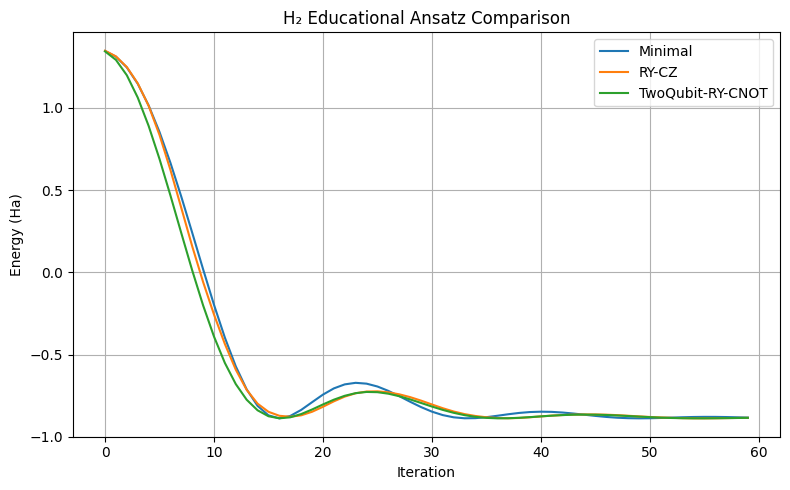

In [6]:
plt.figure(figsize=(8, 5))
for name, data in results_A.items():
    plt.plot(data["energies"], label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ Educational Ansatz Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 6 — Draw the toy circuits


Minimal circuit:


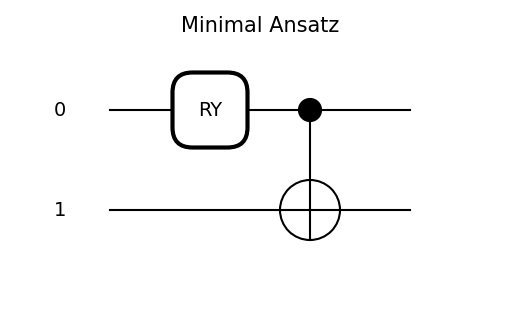


RY-CZ circuit:


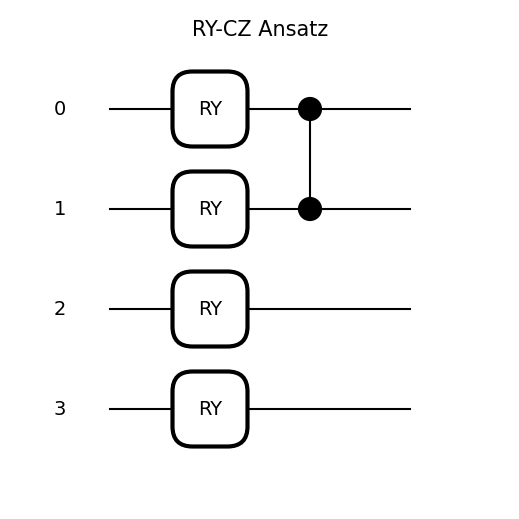


TwoQubit-RY-CNOT circuit:


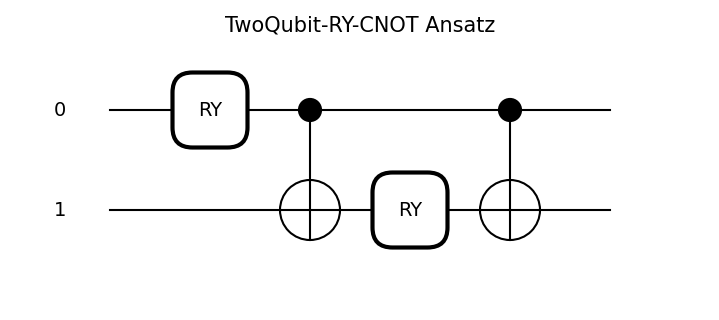

In [7]:
for name, fn in toy_ansatzes.items():
    params = results_A[name]["params"]

    print(f"\n{name} circuit:")
    fig, ax = qml.draw_mpl(fn)(params, wires=range(num_qubits))
    fig.suptitle(f"{name} Ansatz", fontsize=15)
    plt.show()

# 🟦 Part B — Production-Level Ansatz Comparison

Now we repeat using your **packaged VQE engine**:

```python
run_vqe_ansatz_comparison(...)
```

This is the version used in your normal workflows and research experiments.


🔹 Running ansatz: Minimal

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__Minimal__Adam__VQE__noiseless__s0__bf0f67d31a3b.json

🔹 Running ansatz: RY-CZ

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__0311bcaea86c.json

🔹 Running ansatz: TwoQubit-RY-CNOT

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__Adam__VQE__noiseless__s0__8b4cd16e4af4.json
📁 Saved → /workspaces/Variational_Quantum_Eigensolver/images/vqe/VQE_Ansatz_Comparison_H2_Adam.png


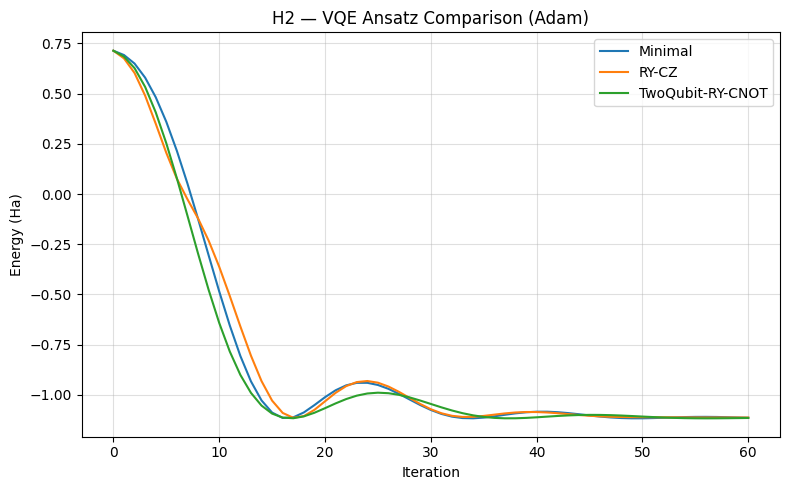


✅ Ansatz comparison complete for H2 (Adam)


{'energies': {'Minimal': [0.7136115947116777,
   0.6921638883523078,
   0.6496410886324888,
   0.5794965246366335,
   0.482265732775808,
   0.35972817395708295,
   0.21488081726325117,
   0.051977278687705804,
   -0.12348266714758883,
   -0.30484916759011876,
   -0.48453450553458516,
   -0.6543749609745103,
   -0.8061763386593684,
   -0.9324665400834391,
   -1.0274412733732332,
   -1.088003034494161,
   -1.1146492087095787,
   -1.1118164841755147,
   -1.0872991623615895,
   -1.0507001887857024,
   -1.011428441165381,
   -0.9770433666171249,
   -0.9524617894216559,
   -0.9399882806588915,
   -0.9398048194683077,
   -0.9505731184064429,
   -0.9699702212778663,
   -0.995118386191784,
   -1.0229347047806823,
   -1.050434826882031,
   -1.0750082844579938,
   -1.0946595765216094,
   -1.1081899064133272,
   -1.1152858444233271,
   -1.116487637389781,
   -1.113031792770026,
   -1.1065934824392505,
   -1.0989814956194737,
   -1.091849096604334,
   -1.0864736385115616,
   -1.0836328614719513,
  

In [8]:
from vqe.core import run_vqe_ansatz_comparison

results_B = run_vqe_ansatz_comparison(
    molecule="H2",
    optimizer_name="Adam",
    ansatzes=["Minimal", "RY-CZ", "TwoQubit-RY-CNOT"],
    steps=60,
    stepsize=0.2,
    noisy=False,
)

results_B